In [2]:
!pip install gymnasium
!pip install 'gymnasium[atari]'
!pip install 'gymnasium[accept-rom-license]'

!pip install torch torchvision torchaudio
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable

import gymnasium as gym
import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [4]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        
        self.fc1 = nn.Linear(32*4*4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [5]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        return Q(obs).argmax().detach().numpy()
    return policy_fn

In [6]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    factor = current_timestep / duration
    eps = max(eps_start + factor * (eps_end - eps_start), eps_end)
    return eps

In [7]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        if self.__len__() < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
            self.position = (self.position + 1) % self.max_size
        return 

    def sample(self, batch_size: int) -> torch.Tensor:
        rands = np.random.randint(0, self.__len__(), size = batch_size)
        obs_b = torch.stack([torch.from_numpy(self.data[i][0]) for i in rands])
        action_b = torch.stack([torch.tensor(self.data[i][1]) for i in rands ])
        reward_b = torch.stack([torch.tensor(self.data[i][2]) for i in rands])
        next_obs_b = torch.stack([torch.from_numpy(self.data[i][3]) for i in rands])
        terminated_b = torch.stack([torch.tensor(self.data[i][4]) for i in rands])
        return (obs_b, action_b, reward_b, next_obs_b, terminated_b)

In [8]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    # Calculate the TD-Target
    with torch.no_grad():
        # Double Q update
        max_action = torch.max(q(next_obs), 1)
        q_val_targ = q_target(next_obs)
        #print(f'Actions: {q1_target(next_obs)}')
        #print(f'Q Values: {max_action.indices}')
        #print(f'Q2 Values: {q2_target(next_obs)}')
        q_value = torch.gather(q_val_targ, 1, max_action.indices.unsqueeze(1)).flatten()
        #print(f'q_val_targ: {q_val_targ}')
        #print(f'Gathered Q_target Values: {q_value}')
        # print(rew)
        td_target = rew + q_value * gamma * (1-torch.Tensor(tm).float())

    
   
    #q.zero_grad()
    optimizer.zero_grad()
    
    pred = torch.gather(q(obs), 1, act.type(torch.int64).unsqueeze(1)).flatten()
    loss_fun = nn.MSELoss()
    loss = loss_fun(td_target, pred)
    loss.backward()
    optimizer.step()
    

In [9]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    # TODO: Calculate the TD-Target
    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    loss = F.mse_loss(q(obs).gather(1, act.type(torch.int64).unsqueeze(1)), td_target.unsqueeze(1))

    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()


In [10]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    for param, target_param in zip(params, target_params):
        target_param.data.mul_(1 - tau)
        target_param.data.add_(param.data * tau)

<h1>DQN</h1>

In [15]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            tau = 0.005,
            inter = True
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.tau = tau
        self.inter = inter

        self.buffer = ReplayBuffer(maxlen)

        self.q = DQN(env.observation_space.shape, env.action_space.n)

        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        self.optimizer = optim.Adam(self.q.parameters(), lr = lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  Transitions: {len(self.buffer)}')
            
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                   
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                    
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(obs, action, reward, next_obs, terminated)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch.float(),
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )
                if current_timestep % self.update_freq == 0 & self.inter:
                    self.q_target.load_state_dict(copy.deepcopy(self.q.state_dict()))
                else:
                    polyak_update(self.q.parameters(), self.q_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

<h1>DDQN</h1>

In [16]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            tau = 0.005,
            inter = True
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.tau = tau
        self.inter = inter

        self.buffer = ReplayBuffer(maxlen)

        self.q = DQN(env.observation_space.shape, env.action_space.n)

        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        self.optimizer = optim.Adam(self.q.parameters(), lr = lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  Transitions: {len(self.buffer)}')
            
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                   
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                    
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(obs, action, reward, next_obs, terminated)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Q network
                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch.float(),
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )
                if current_timestep % self.update_freq == 0 & self.inter:
                    self.q_target.load_state_dict(copy.deepcopy(self.q.state_dict()))
                else:
                    polyak_update(self.q.parameters(), self.q_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

<h1>Hyperparameters</h1>

In [35]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit

LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 75
EPS_START = 0.7
EPS_END = 0.05
SCHEDULE_DURATION = 100_000
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
TAU = 0.005

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



<h1>Agent Versions</h1>

In [36]:
agent_ddqn_poly = DDQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU,
    inter = False,
)
agent_dqn_poly = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU,
    inter = False,
)
agent_ddqn_inter = DDQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU,
    inter = True,
)
agent_dqn_inter = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU,
    inter = True,
)

In [37]:
print("Training DDQN Polyak")
stats_ddqn_poly = agent_ddqn_poly.train(NUM_EPISODES)
print("Training DDQN Interval")
stats_ddqn_inter = agent_ddqn_inter.train(NUM_EPISODES)
print("Training DQN Polyak")
stats_dqn_poly = agent_dqn_poly.train(NUM_EPISODES)
print("Training DQN Interval")
stats_dqn_inter = agent_dqn_inter.train(NUM_EPISODES)

Training DDQN Polyak
Episode 100 of 1000  Time Step: 4881  Epsilon: 0.668  Transitions: 4881
Episode 200 of 1000  Time Step: 11611  Epsilon: 0.625  Transitions: 11611
Episode 300 of 1000  Time Step: 20007  Epsilon: 0.570  Transitions: 20007
Episode 400 of 1000  Time Step: 27613  Epsilon: 0.521  Transitions: 27613
Episode 500 of 1000  Time Step: 36853  Epsilon: 0.460  Transitions: 36853
Episode 600 of 1000  Time Step: 46770  Epsilon: 0.396  Transitions: 46770
Episode 700 of 1000  Time Step: 58471  Epsilon: 0.320  Transitions: 58471
Episode 800 of 1000  Time Step: 70766  Epsilon: 0.240  Transitions: 70766
Episode 900 of 1000  Time Step: 84159  Epsilon: 0.153  Transitions: 84159
Episode 1000 of 1000  Time Step: 102731  Epsilon: 0.050  Transitions: 100000
Training DDQN Interval
Episode 100 of 1000  Time Step: 6132  Epsilon: 0.660  Transitions: 6132
Episode 200 of 1000  Time Step: 13242  Epsilon: 0.614  Transitions: 13242
Episode 300 of 1000  Time Step: 23239  Epsilon: 0.549  Transitions: 2

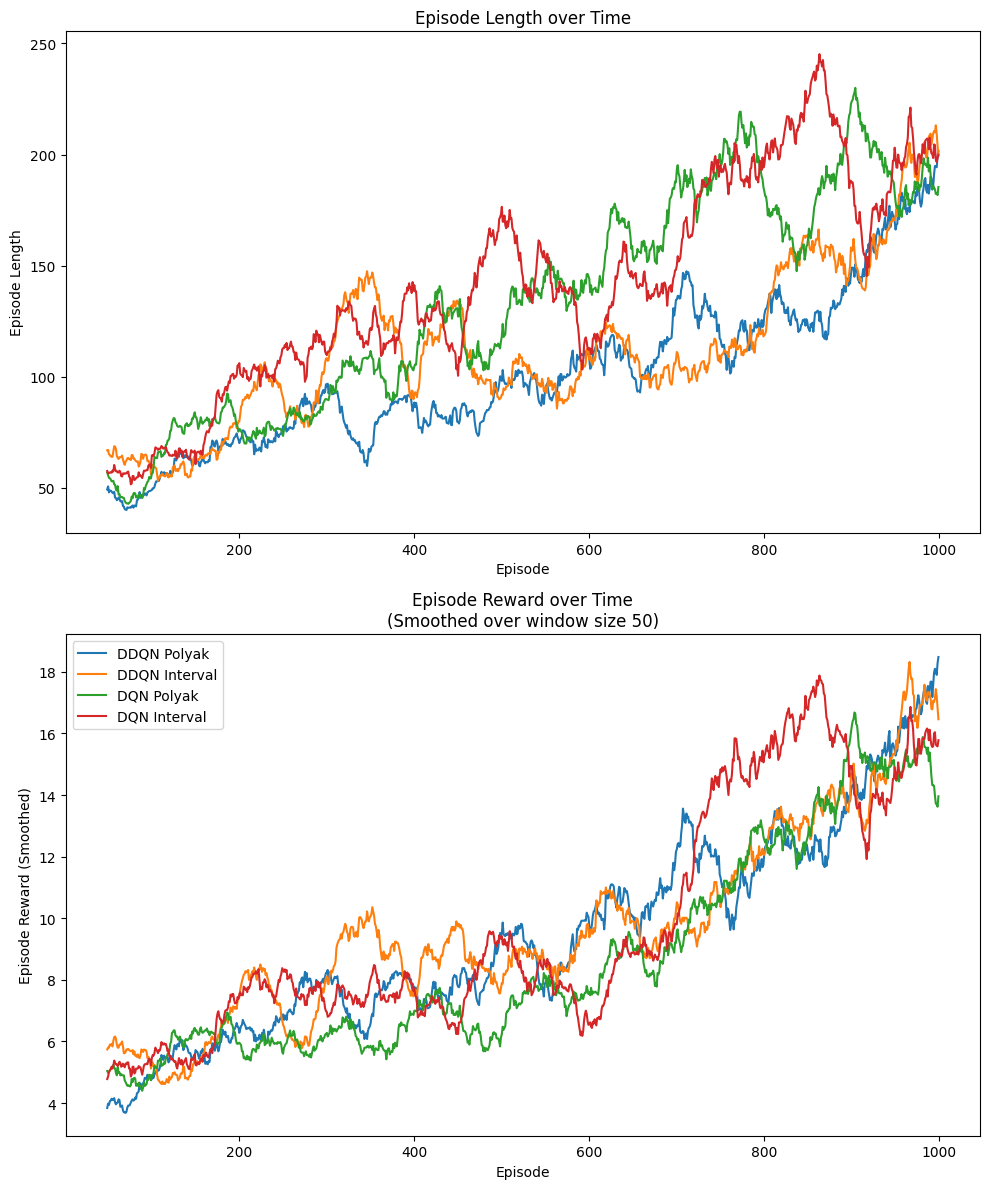

In [44]:
smoothing_window=50
fig, axes = plt.subplots(2, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ddqnp_ep = pd.Series(stats_ddqn_poly.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ddqni_ep = pd.Series(stats_ddqn_inter.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
dqnp_ep = pd.Series(stats_dqn_poly.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
dqni_ep = pd.Series(stats_dqn_inter.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax = axes[0]
ax.plot(ddqnp_ep, label = "DDQN Polyak")
ax.plot(ddqni_ep, label = "DDQN Interval")
ax.plot(dqnp_ep, label = "DQN Polyak")
ax.plot(dqni_ep, label = "DQN Interval")
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")  
# Plot the episode reward over time
ddqnp_rew = pd.Series(stats_ddqn_poly.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ddqni_rew = pd.Series(stats_ddqn_inter.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
dqnp_rew = pd.Series(stats_dqn_poly.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
dqni_rew = pd.Series(stats_dqn_inter.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax = axes[1]
ax.plot(ddqnp_rew, label = "DDQN Polyak")
ax.plot(ddqni_rew, label = "DDQN Interval")
ax.plot(dqnp_rew, label = "DQN Polyak")
ax.plot(dqni_rew, label = "DQN Interval")
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.legend() 
plt.show()


/Users/Meow/miniconda3/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/Users/Meow/miniconda3/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


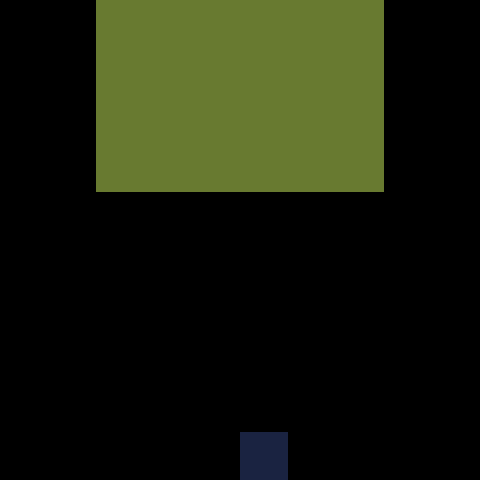

In [39]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent_ddqn_inter.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")